# Scaling with the number of timesteps

*How faster is NAVIX than MiniGrid?* 

In this notebook, we will answer this question by comparing the two libraries in terms of their performance.

We will look at:
- The raw time it takes to run 100_000 episodes of a simple environment in both libraries.
- How the performance scales with the number of parallel environments

#### TL;DR;

NAVIX is **at least** $10\times$ faster than MiniGrid. The performance of NAVIX scales constantly with the number of parallel environments up to $10^4$, after which it starts to scale at least linearly, probably due to memory saturation.

---

#### Benchmarking Minigrid

Let's start with MiniGrid.

In [1]:
import os
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
# See https://stackoverflow.com/questions/51464455/how-to-disable-welcome-message-when-importing-pygame

In [2]:
import gymnasium as gym
import timeit
import matplotlib.pyplot as plt

num_steps_set = (
    10,
    100,
    1_000,
    10_000,
    100_000,
    1_000_000,
)  # we won't for further because MiniGrid becomes too slow

def benchmark_minigrid(num_steps):
    env = gym.make("MiniGrid-Empty-8x8-v0")
    env.reset()

    for _ in range(num_steps):
        action = env.action_space.sample()
        timestep = env.step(action)
    return timestep

minigrid_times = {}
for i in num_steps_set:
    minigrid_times[i] = timeit.timeit(lambda: benchmark_minigrid(i), number=1)

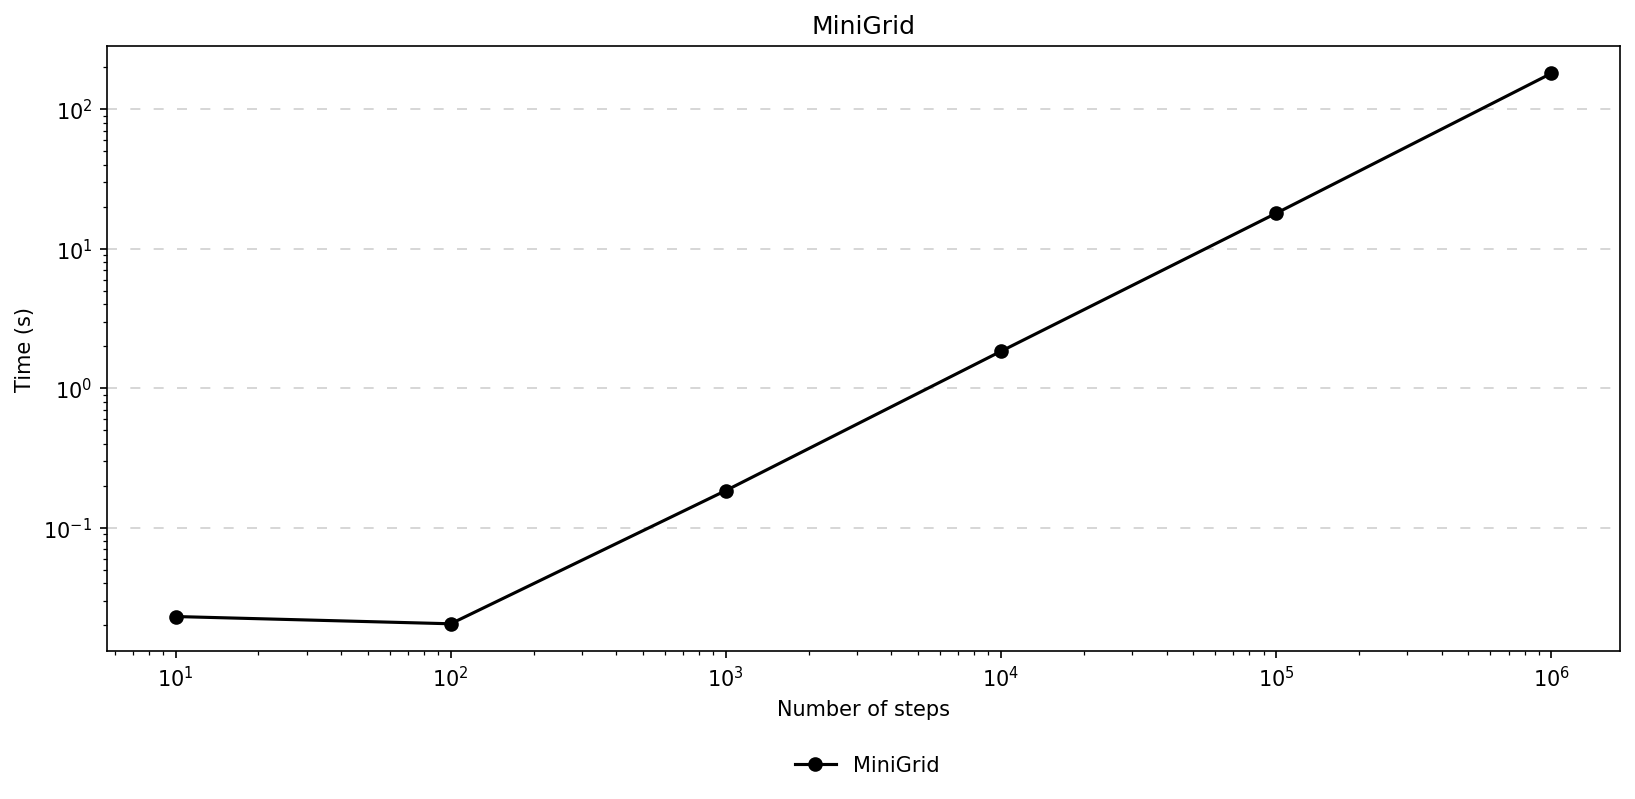

In [3]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
ax.plot(minigrid_times.keys(), minigrid_times.values(), label="MiniGrid", color="black", marker="o")
ax.set_xlabel("Number of steps")
ax.set_ylabel("Time (s)")
ax.set_title("MiniGrid")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(axis="y", linestyle=(0, (6, 8)), alpha=0.6)
fig.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.53, -0.07), shadow=False, frameon=False)
fig.tight_layout()
plt.show()

It scales quite linearly with the number of steps. That's a reasonable time for a single environment that runs on the CPU.

#### Benchmarking NAVIX

Let's see how NAVIX compares to MiniGrid with a single environment.

In [5]:
import functools
import jax
import navix as nx


@functools.partial(jax.jit, static_argnums=1)
def benchmark_navix(seed, num_steps):
    env = nx.make("Navix-Empty-8x8-v0")  # Create the environment
    timestep = env.reset(seed)
    actions = jax.random.randint(seed, (num_steps,), 0, env.action_space.n)

    def body_fun(timestep, action):
        timestep = env.step(timestep, action)  # Update the environment state
        return timestep, ()

    return jax.lax.scan(body_fun, timestep, actions, unroll=10)[0]


seed = jax.random.PRNGKey(0)
navix_times = {}
for i in num_steps_set:
    benchmark_navix_jit = benchmark_navix.lower(seed, i).compile()  # AOT compilation
    navix_times[i] = timeit.timeit(lambda: benchmark_navix_jit(seed), number=1)

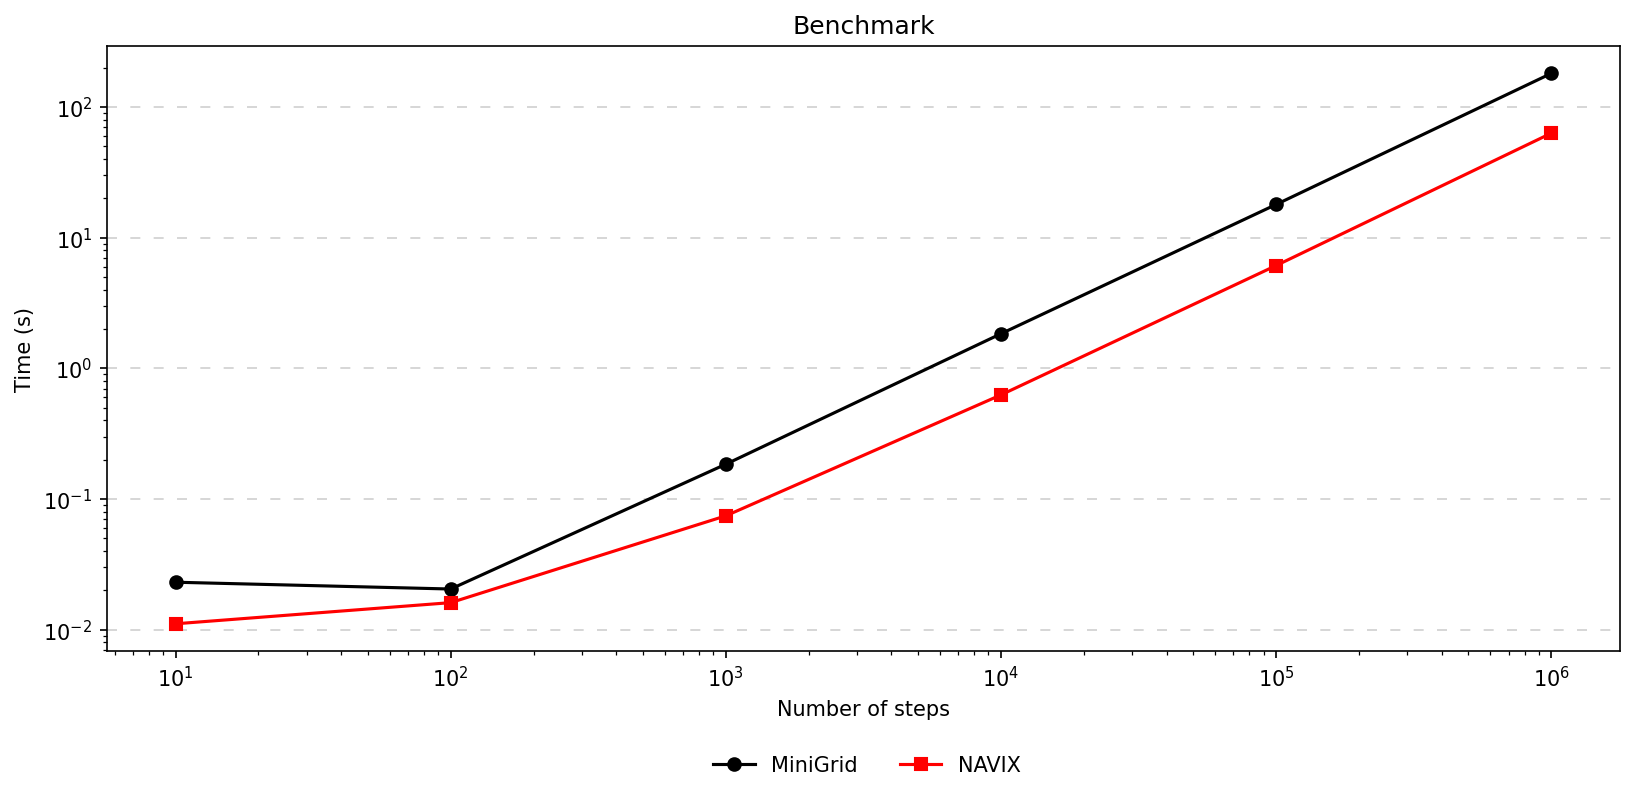

In [10]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
ax.plot(minigrid_times.keys(), minigrid_times.values(), label="MiniGrid", color="black", marker="o")
ax.plot(navix_times.keys(), navix_times.values(), label="NAVIX", color="red", marker="s")
ax.set_xlabel("Number of steps")
ax.set_ylabel("Time (s)")
ax.set_title("Benchmark")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(axis="y", linestyle=(0, (6, 8)), alpha=0.6)
fig.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.53, -0.07), shadow=False, frameon=False)
fig.tight_layout()
plt.show()

## Conclusions 

The plot shows that NAVIX is about $10 \times$ faster than MiniGrid for a single environment at $10^6$ steps.

This is not all. NAVIX is designed to scale with the number of parallel environments. Let's see how it performs in the batched case with the next benchmark.

In [1]:
import jax
import navix as nx

env_id = "Navix-KeyCorridorS3R1-v0"
env = nx.make(env_id)
seed = jax.random.PRNGKey(0)
timestep = env.reset(seed)
timestep = env.step(timestep, env.action_space.sample(seed))

TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'